# Run code in this section before executing the different sections and change event # depending on specific match

In [1]:
# Importing Libraries

import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from IPython.display import display
import json
import os

# Setting default text color
rcParams['text.color'] = '#c7d5cc' # Comment this out for the Argentinian Passing Network

In [2]:
# Using Sbopen() to open event data, related events data, freeze frame data, and tactics data from the world cup final using its respective match id

parser = Sbopen()
df, related, freeze, tactics = parser.event(3869685)

In [3]:
# Viewing the contents of the retrieved data

print(freeze)
print(df)
print(related)
print(tactics)

     teammate  match_id                                    id      x     y  \
0       False   3869685  545c2c84-018f-4570-a01c-753823feaeac  101.0  48.0   
1       False   3869685  545c2c84-018f-4570-a01c-753823feaeac  102.8  36.1   
2       False   3869685  545c2c84-018f-4570-a01c-753823feaeac  103.0  26.7   
3       False   3869685  545c2c84-018f-4570-a01c-753823feaeac  101.9  21.4   
4       False   3869685  545c2c84-018f-4570-a01c-753823feaeac   98.6  27.9   
..        ...       ...                                   ...    ...   ...   
353     False   3869685  449f2702-ad18-4bc8-a9ef-59fb1dc1a707  118.1  42.4   
354      True   3869685  449f2702-ad18-4bc8-a9ef-59fb1dc1a707  119.2  58.0   
355      True   3869685  449f2702-ad18-4bc8-a9ef-59fb1dc1a707  100.8  54.5   
356      True   3869685  449f2702-ad18-4bc8-a9ef-59fb1dc1a707  101.9  38.8   
357     False   3869685  54e27ba9-b9ae-44a3-ac8d-fc91e76a1b91  119.9  40.0   

     player_id                      player_name  position_id  \

# Argentinian Passing Network During 2022 World Cup Final

In [4]:
# Check for index of first substitution
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Argentina"].iloc[0]["index"]

# Make a dataframe with successful passes by Argentina until the first substitution
mask_argentina = (df.type_name == 'Pass') & (df.team_name == "Argentina") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
df_pass = df.loc[mask_argentina, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

# Checking for index of first substitution
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Argentina"].iloc[0]["index"]
# Making a dataframe with successfull passes by Argentina until the first substitution
mask_argentina = (df.type_name == 'Pass') & (df.team_name == "Argentina") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
# Taking necessary columns
df_pass = df.loc[mask_argentina, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

In [5]:
# Creating a new empty dataframe 
scatter_df = pd.DataFrame()

# Iterating over dataframe for specific data within columns 
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
# Making sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
# Calculating the number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# Adjusting the size of the circles so that it is larger for players who make more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [6]:
# Counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
# Setting a treshold for number of passes
lines_df = lines_df[lines_df['pass_count']>0] #2 is the default nunber they use to narrow it down a little - 0 shows all of the passes

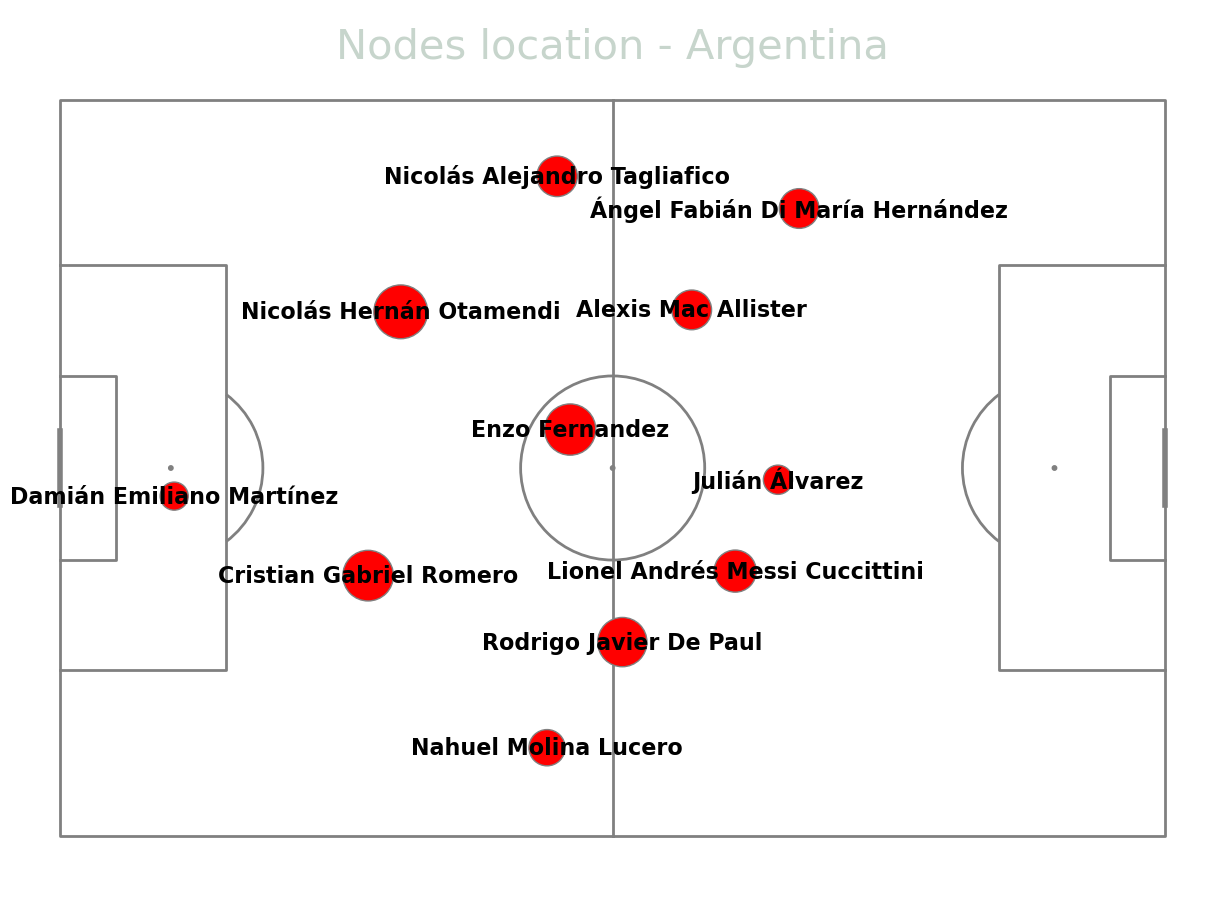

In [7]:
# Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
# Annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - Argentina", fontsize = 30)
plt.show()

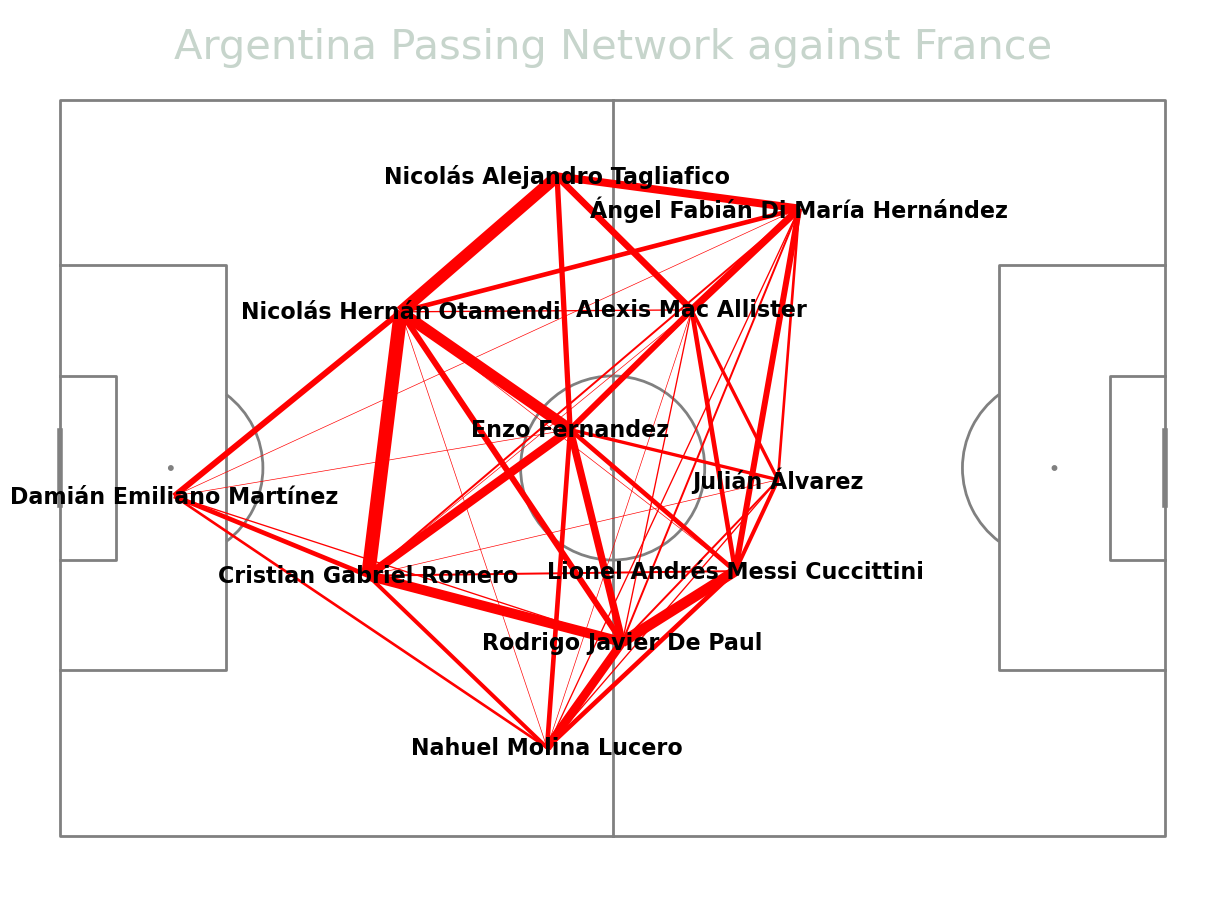

In [8]:
# Plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plotting pass networks based on pair key and average location 
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)
# Iterating over the rows for passes between players and their locations
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        # Taking the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        # Adjusting the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        # Plotting the lines
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("Argentina Passing Network against France", fontsize = 30)
plt.show()

In [ ]:
## Code template used from 
#https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PassNetworks.html

# Messi's passes by foot during 2022 World Cup Final

In [ ]:
# Creating an identifyer for Messi's passes
mask_messi = (df.type_name == 'Pass') & (df.player_id == 5503)

In [ ]:
# Creating a dataframe 
df_pass = df.loc[mask_messi, ['x', 'y', 'end_x', 'end_y', 'outcome_name', 'id', 'body_part_name']]
mask_complete = df_pass.outcome_name.isnull()

In [ ]:
df_pass.head()

In [ ]:
# Filter the dataframe for Messi's left-footed passes
mask_messi_left = (df_pass['body_part_name'] == 'Left Foot') & (df.type_name == 'Pass') & (df.player_id == 5503)
mask_messi_right = (df_pass['body_part_name'] == 'Right Foot') & (df.type_name == 'Pass') & (df.player_id == 5503)

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Plot the left-footed completed passes
lc1 = pitch.lines(df_pass[mask_messi_left & mask_complete].x, df_pass[mask_messi_left & mask_complete].y,
                  df_pass[mask_messi_left & mask_complete].end_x, df_pass[mask_messi_left & mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='completed left-footed passes',
                  color='#ad993c', ax=ax)

# Plot the other left-footed passes
lc2 = pitch.lines(df_pass[mask_messi_left & ~mask_complete].x, df_pass[mask_messi_left & ~mask_complete].y,
                  df_pass[mask_messi_left & ~mask_complete].end_x, df_pass[mask_messi_left & ~mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='other left-footed passes',
                  color='#ba4f45', ax=ax)

# Plot the legend
ax.legend(facecolor='#22312b', edgecolor='None', fontsize=20, loc='upper left', handlelength=4)

# Set the title
fig.suptitle("Messi's left-footed passes vs France", fontsize=30)

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Plot the right-footed completed passes
lc1 = pitch.lines(df_pass[mask_messi_right & mask_complete].x, df_pass[mask_messi_right & mask_complete].y,
                  df_pass[mask_messi_right & mask_complete].end_x, df_pass[mask_messi_right & mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='completed right-footed passes',
                  color='#ad993c', ax=ax)

# Plot the other right-footed passes
lc2 = pitch.lines(df_pass[mask_messi_right & ~mask_complete].x, df_pass[mask_messi_right & ~mask_complete].y,
                  df_pass[mask_messi_right & ~mask_complete].end_x, df_pass[mask_messi_right & ~mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='other right-footed passes',
                  color='#ba4f45', ax=ax)

# Plot the legend
ax.legend(facecolor='#22312b', edgecolor='None', fontsize=20, loc='upper left', handlelength=4)

# Set the title
fig.suptitle("Messi's right-footed passes vs France", fontsize=30)

# Messi's Total Passes during 2022 World Cup Final

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Plot the completed passes
lc1 = pitch.lines(df_pass[mask_complete].x, df_pass[mask_complete].y,
                  df_pass[mask_complete].end_x, df_pass[mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='completed passes',
                  color='#ad993c', ax=ax)

# Plot the other passes
lc2 = pitch.lines(df_pass[~mask_complete].x, df_pass[~mask_complete].y,
                  df_pass[~mask_complete].end_x, df_pass[~mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='other passes',
                  color='#ba4f45', ax=ax)

# Plot the legend
ax.legend(facecolor='#22312b', edgecolor='None', fontsize=20, loc='upper left', handlelength=4)

# Set the title
fig.suptitle("Messi's total passes vs France", fontsize = 30)

# Messi's Incomplete Passes During 2020-21 La Liga Season

In [2]:
# Open the data and assign it to 'df'dataframe
parser = Sbopen()
df = parser.match(competition_id=11, season_id=90)

In [3]:
# Looking at the columns within the dataframe
print (df.columns)

Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition_id', 'country_name', 'competition_name',
       'season_id', 'season_name', 'home_team_id', 'home_team_name',
       'home_team_gender', 'home_team_group', 'home_team_country_id',
       'home_team_country_name', 'home_team_managers_id',
       'home_team_managers_name', 'home_team_managers_nickname',
       'home_team_managers_dob', 'home_team_managers_country_id',
       'home_team_managers_country_name', 'away_team_id', 'away_team_name',
       'away_team_gender', 'away_team_group', 'away_team_country_id',
       'away_team_country_name', 'away_team_managers_id',
       'away_team_managers_name', 'away_team_managers_nickname',
       'away_team_managers_dob', 'away_team_managers_country_id',
       'away_team_managers_country_name', 'metadata_data_version',
       'metadata_shot_fidelity_version', 'm

In [4]:
team = "Barcelona"

# Get list of games by Barcelona, either home or away
match_ids = df.loc[(df["home_team_name"] == team) | (df["away_team_name"] == team)]["match_id"].tolist()

# Calculate number of games
no_games = len(match_ids)

In [5]:
# Viewing filtered match ids and number of matches during the season
print(match_ids)
print(no_games)

[3773457, 3773631, 3773665, 3773497, 3773660, 3773593, 3773466, 3773585, 3773552, 3773672, 3773386, 3773565, 3773587, 3773656, 3773377, 3773586, 3773372, 3773387, 3773695, 3773369, 3773661, 3773597, 3773523, 3773571, 3773428, 3764661, 3773526, 3773474, 3773625, 3773403, 3773547, 3773415, 3764440, 3773689, 3773477]
35


In [ ]:
# Declaring an empty dataframe for danger passes
incomplete_passes = pd.DataFrame()
for idx in match_ids:
    # Opening the event data for this match
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keeping only accurate passes by Messi that were not set pieces in this period
        mask_pass = (df.player_id == 5503) & (df.type_name == "Pass") & (df.outcome_name == "Incomplete") & (df.sub_type_name.isnull())
        # Keeping necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "under_pressure"]]
        
        # Concatenating dataframe with a previous one to keep danger passes from the whole season
        incomplete_passes = pd.concat([incomplete_passes, passes], ignore_index = True)

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Plot the incomplete passes under pressure
lc1 = pitch.scatter(incomplete_passes[incomplete_passes['under_pressure'] == True].x,
                    incomplete_passes[incomplete_passes['under_pressure'] == True].y,
                    s=100, label='incomplete passes under pressure', color='red', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax)

# Plot the other incomplete passes
lc2 = pitch.scatter(incomplete_passes[incomplete_passes['under_pressure'].isnull()].x,
                    incomplete_passes[incomplete_passes['under_pressure'].isnull()].y,
                    s=100, label='other incomplete passes', color='orange', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax)

# Plot the legend
ax.legend(facecolor='#22312b', edgecolor='None', fontsize=20, loc='upper left', handlelength=4)

# Set the title
fig.suptitle("Messi's incomplete passes during the 2020-21 La Liga Season", fontsize=30)

# Messi's Danger Passes Heat Map For La Liga Seasons

In [ ]:
# Open the data and assign it to 'df'dataframe
parser = Sbopen()
# Selecting the 2020-21 La Liga Season
df = parser.match(competition_id=11, season_id=90) 
# For 2014-15 season: (competition_id=11, season_id=26)
# For 2017-18 season: (competition_id=11, season_id=1)

In [ ]:
# Looking at the columns within the dataframe
print (df.columns)

In [ ]:
team = "Barcelona"

# Get list of games by Barcelona, either home or away
match_ids = df.loc[(df["home_team_name"] == team) | (df["away_team_name"] == team)]["match_id"].tolist()

# Calculate number of games
no_games = len(match_ids)

In [ ]:
# Viewing filtered match ids and number of matches during the season
print(match_ids)
print(no_games)

In [ ]:
# Declaring an empty dataframe for danger passes
danger_passes = pd.DataFrame()
for idx in match_ids:
    # Opening the event data for this match
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keeping only accurate passes by Messi that were not set pieces in this period
        mask_pass = (df.player_id == 5503) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        # Keeping necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_id"]]
        # Keeping only Shots by Barcelona in this period
        mask_shot = (df.player_id == 5503) & (df.type_name == "Shot") & (df.period == period)
        # Keeping necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        # Converting time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        # Finding the start of the window
        shot_start = shot_times - shot_window
        # Condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        # Converting to seconds
        pass_times = passes['minute']*60+passes['second']
        # Checking if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # Keeping only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        # Concatenating dataframe with a previous one to keep danger passes from the whole season
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [ ]:
# Plotting pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Plotting danger pass locations on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

# Title
fig.suptitle('Location of danger passes by Messi during 2020-21 La Liga Season', fontsize = 30) #Replace '2020-21' with '2014-15' or '2017-18' if you are using data from those seasons 
plt.show()

In [ ]:
# Plotting vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Getting the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
# Normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
# Making a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
# Adding a legend and subtitle
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Messi' + " Per Game During 2020-21 La Liga Season", fontsize = 30) #Replace '2020-21' with '2014-15' or '2017-18' if you are using data from those seasons 
plt.show()

# Plotting Messi's Assist vs Netherlands During 2022 World Cup Quarterfinal

In [ ]:
sb.competitions()

In [ ]:
# Filtering for specific season
sb.matches(competition_id=43, season_id=106).head(50)

In [ ]:
# Filtering for specific match
MATCH_ID = 3869321

In [ ]:
# Creating the events dataframe
match_events_df = sb.events(match_id=MATCH_ID)

In [ ]:
# Manually importing the Statsbomb 360 data
match_360_df = pd.read_json(f'C:/Users/PC/OneDrive/Documents/GitHub/open-data/data/three-sixty/{MATCH_ID}.json')
    
#(f'/Users/fadihaddad/Documents/GitHub/open-data/data/three-sixty/{MATCH_ID}.json') for MAC

#(f'C:/Users/PC/OneDrive/Documents/GitHub/open-data/data/three-sixty/{MATCH_ID}.json') for PC

In [ ]:
# Merging the two dataframes by using the match 'id' from the events dataframe and the 'event_uuid' from the match_360 dataframe
df = pd.merge(left=match_events_df, right=match_360_df, left_on='id', right_on='event_uuid', how='left')

In [ ]:
# Viewing the merged dataframe
df.head(25)
df.columns

In [ ]:
# Filtering for Messi's passes
MESSI = 5503

df = df[(df['player_id'] == MESSI) & (df['type'] == 'Pass')].reset_index(drop=True)

In [ ]:
# checking to see if the specific event data had match_360 data available

print(df.event_uuid)

In [ ]:
print(df.id)

In [ ]:
# Defining the dataframe with the following columns to be used for plotting the start and end location of Messi's passes
df[['x_start', 'y_start']] = pd.DataFrame(df.location.tolist(), index=df.index)
df[['x_end', 'y_end']] = pd.DataFrame(df.pass_end_location.tolist(), index=df.index)

In [ ]:
# Viewing location of the passes
df.location

In [ ]:
# Setup the pitch
p = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = p.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Specifying plotted pass to plot row 14
df_row = df.iloc[14]

# Plotting the pass
p.scatter(x=df_row['x_start'], y=df_row['y_start'], ax=ax)
p.lines(xstart=df_row['x_start'], ystart=df_row['y_start'], xend=df_row['x_end'], yend=df_row['y_end'], color='#ad993c', ax=ax)

# Plotting surrounding players from 'freeze_frame' column
for x in df_row['freeze_frame']:
    if x['teammate']:
        color='#ad993c'
    else:
        color='#ba4f45'
    p.scatter(x=x['location'][0], y=x['location'][1], ax=ax, c=color, s=100)
    
fig.suptitle("Messi's assist vs Netherlands during 2022 World Cup Quarterfinal", fontsize = 30)

# Plotting Messi's pass to shot vs Netherlands During 2022 World Cup Quarterfinal

In [ ]:
# Setup the pitch
p = Pitch(pitch_type='statsbomb')
fig, ax = p.draw(figsize=(12, 8))

# Specifying plotted pass to plot row 43
df_row = df.iloc[43]

p.scatter(x=df_row['x_start'], y=df_row['y_start'], ax=ax)
p.lines(xstart=df_row['x_start'], ystart=df_row['y_start'], xend=df_row['x_end'], yend=df_row['y_end'], ax=ax)

for x in df_row['freeze_frame']:
    if x['teammate']:
        color = 'blue'
    else:
        color = 'red'
    p.scatter(x=x['location'][0], y=x['location'][1], ax=ax, c=color, s=100)
    
fig.suptitle("Messi's pass to shot vs Netherlands during 2022 World Cup Quarterfinal", fontsize = 30)

# Plotting Messi's Pass Under Pressure vs France During 2022 World Cup Final

In [ ]:
# Retrieving event data for specific match
MATCH_ID = 3869685

In [ ]:
# Defining 'under_pressure_values'
under_pressure_values = match_events_df['under_pressure']

In [ ]:
df['under_pressure_values'] = under_pressure_values

In [ ]:
# Looking at the data for this column
df.under_pressure_values

In [ ]:
# Replicating the process with 'pass outcome'
pass_outcome_values = match_events_df['pass_outcome']

In [ ]:
df['pass_outcome_values'] = pass_outcome_values

In [ ]:
# Filling null values with 'Complete'
df['pass_outcome_values'] = df['pass_outcome_values'].fillna('Complete')

In [ ]:
df.pass_outcome_values

In [ ]:
df.location

In [ ]:
# Displaying the values from 'pass_outcome_values' where 'under_pressure_values' is True
indexes = df[df['under_pressure_values'] == True].index
output_values = df.loc[indexes, 'pass_outcome_values']
print(output_values)

In [ ]:
# Setup the pitch
p = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = p.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Specifying plotted pass to plot row 27
df_row = df.iloc[27]

# Plotting the pass
p.scatter(x=df_row['x_start'], y=df_row['y_start'], ax=ax)
p.lines(xstart=df_row['x_start'], ystart=df_row['y_start'], xend=df_row['x_end'], yend=df_row['y_end'], color='#ad993c', ax=ax)

# Plotting surrounding players from 'freeze_frame' column
for x in df_row['freeze_frame']:
    if x['teammate']:
        color='#ad993c'
    else:
        color='#ba4f45'
    p.scatter(x=x['location'][0], y=x['location'][1], ax=ax, c=color, s=100)

# Title    
fig.suptitle("Pass Under Pressure vs France during 2022 World Cup Final", fontsize = 30)

# Messi's Progressive Passes vs France During 2022 World Cup Final

In [ ]:
# Manually inputting the location of his passes and creating 'Beginning' and 'end' columns

df = pd.DataFrame({'location': [
    [76.6, 35.7],
    [99.3, 57.3],
    [67.9, 59.0],
    [81.8, 65.2],
    [39.2, 48.1],
    [120.0, 80.0],
    [108.2, 74.4],
    [80.5, 47.8],
    [52.5, 56.4],
    [95.2, 48.5],    
    [89.3, 58.8],
    [89.5, 65.0],
    [120.0, 80.0],
    [81.8, 38.6],
    [45.8, 59.4],
    [68.1, 54.5],
    [92.7, 47.6],
    [80.3, 57.7],
    [52.9, 61.8],
    [48.0, 42.5],
    [44.6, 28.4],
    [37.5, 53.8],
    [80.3, 56.4],
    [82.0, 22.8],
    [61.0, 40.1],    
    [70.6, 21.1],
    [100.4, 65.2],
    [81.3, 32.9],
    [77.5, 74.6],
    [92.4, 60.9],
    [120.0, 80.0],
    [67.6, 71.8],
    [64.0, 43.4],
    [74.7, 19.8],
    [97.8, 9.6],
    [57.6, 59.6],
    [32.6, 72.9],
    [106.8, 23.9],
    [49.0, 66.5],
    [85.6, 72.7],
    [86.7, 76.1],
    [92.9, 64.8],
    [61.0, 40.1],
    [75.8, 60.3],
    [94.6, 61.1],
    [83.0, 51.3],
    [120.0, 0.1],
    [30.4, 27.5],
    [101.4, 35.2],
    [79.8, 72.0],
    [78.3, 73.9],
    [73.6, 46.8],
    [86.0, 34.4],
    [103.4, 37.6],
    [120.0, 0.1],
    [92.9, 60.1],
    [91.2, 58.8],
    [120.0, 0.1],
    [74.1, 34.6],
    [66.8, 62.6],
]})

df[['end_x', 'end_y']] = df['location'].shift(-1)[:-1].apply(lambda coord: pd.Series([coord[0], coord[1]]))

df['Beginning'] = np.sqrt(np.square(120 - df['location'].apply(lambda coord: coord[0])) +
                          np.square(40 - df['location'].apply(lambda coord: coord[1])))

df['end'] = np.sqrt(np.square(120 - df['end_x']) + np.square(40 - df['end_y']))

In [ ]:
# Extracting 'x' and 'y' values from 'location' column
df['x'] = df['location'].str[0]
df['y'] = df['location'].str[1]

In [ ]:
df.head(20)

In [ ]:
# Defining progressive pass
df['progressive'] = [(df['end'][x]) / (df['Beginning'][x]) < .75 for x in range(len(df.Beginning))]

In [ ]:
# Filtering for passes that were progressive
df = df.loc[df['progressive']==True].reset_index()

In [ ]:
pass_outcome_values = match_events_df['pass_outcome']
df['pass_outcome_values'] = pass_outcome_values

In [ ]:
# Filling null values with 'Complete'
df['pass_outcome_values'] = df['pass_outcome_values'].fillna('Complete')

In [ ]:
df.pass_outcome_values

In [ ]:
# Viewing passes that were progressive
df.progressive

In [ ]:
# Setup the pitch
p = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = p.draw(figsize=(12,8), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Iterating over the rows to plot the specified passes
for _, row in df.iterrows():
    x_start, y_start = row['x'], row['y']
    x_end, y_end = row['end_x'], row['end_y']
    
    if row['pass_outcome_values'] == 'Complete':
        color='#ad993c'  
    else:
        color='#ba4f45'  
        
    p.lines(x_start, y_start, x_end, y_end, ax=ax, transparent=True, comet=True, color=color)
    
fig.suptitle("Messi's progressive passes vs France during 2022 World Cup Final", fontsize=30)
        
plt.show()